In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pymongo as mongo

from sklearn.decomposition import NMF


from sklearn.cluster import DBSCAN, AgglomerativeClustering, FeatureAgglomeration, linkage_tree
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from scipy.cluster.hierarchy import dendrogram, distance, fcluster, cophenet, set_link_color_palette, linkage
from scipy.spatial.distance import squareform, pdist

from multiprocessing import Pool
import pickle
from sys import getsizeof
import psutil


In [2]:
# Load Data
text_data = None
joined = None
cleaned = None
cvectr = None
nmf = None
text_nmf = None
components_df = None

with open('WranglingPickles/text_data.pkl', 'rb') as f:
    tex_data = pickle.load(f)
    
with open('WranglingPickles/cleaned.pkl', 'rb') as f:
    cleaned = pickle.load(f)
    
with open('WranglingPickles/cvectr.pkl', 'rb') as f:
    cvectr = pickle.load(f)
    
with open('WranglingPickles/nmf.pkl', 'rb') as f:
    nmf = pickle.load(f)
    
with open('WranglingPickles/text_nmf.pkl', 'rb') as f:
    text_nmf = pickle.load(f)
    
with open('WranglingPickles/components_df.pkl', 'rb') as f:
    components_df = pickle.load(f)
    
with open('Joined.pkl','rb') as f:
    joined = pickle.load(f)

/home/rshap/anaconda3/lib/python3.5/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator CountVectorizer from version pre-0.18 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rshap/anaconda3/lib/python3.5/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator NMF from version pre-0.18 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Sorry need to redo components_df so it's sorted according to word importance

In [4]:
wdic = {i:w for w,i in cvectr.vocabulary_.items()}

In [5]:
top25 = {}

for i in range(len(nmf.components_)):# for each component
    # sort the words in the components by importance, but grab the original indices
    idxs = np.argsort(nmf.components_[i])[-1:-26:-1]
    # use idxs to extract corresponding words from wordDic
    top25['ftr_'+str(i)] = [wdic[i] for i in idxs]

In [11]:
# It's the same thing just each column is sorted
components_df = pd.DataFrame(top25)

# reorder columns so ftr_10 comes after ftr_9...
components_df = components_df[['ftr_'+str(i) for i in range(len(top25.keys()))]]


In [13]:
cols = ['Dependency', 'Coding_Latex', 'Cancer_Genetics','Depression_ADHD', 
        'Pain_MotorFunction','Neurons', 'Sleep','BrainMapping', 
        'Alzheimers_Dementia_Parkinson', 'Animal_Experiments',
        'Brain_Modelling', 'Stroke_Aneurysm_Damage', 'Memory', 
        'Attention', 'Psychiatric_Disorder', ]

components_df.columns = cols

components_df.to_csv('csvs/components_df.csv')
components_df

,Dependency,Coding_Latex,Cancer_Genetics,Depression_ADHD,Pain_MotorFunction,Neurons,Sleep,BrainMapping,Alzheimers_Dementia_Parkinson,Animal_Experiments,Brain_Modelling,Stroke_Aneurysm_Damage,Memory,Attention,Psychiatric_Disorder
0,receptor,usepackage,cells,depression,pain,neurons,sleep,cortex,alzheimer,mice,network,stroke,memory,visual,schizophrenia
1,expression,document,cell,disorder,spinal,neuron,rem,regions,ad,fig,spike,cerebral,cognitive,task,psychiatry
2,receptors,end,expression,disorders,mg,cortex,insomnia,connectivity,amyloid,mouse,synaptic,risk,learning,stimulus,symptoms
3,protein,begin,fig,psychiatry,nerve,fig,eeg,cortical,aβ,expression,neural,ischemic,task,stimuli,cognitive
4,rats,minimal,protein,anxiety,injury,cortical,circadian,matter,dementia,wt,input,acute,performance,trials,antipsychotic
5,induced,amsbsy,stem,symptoms,surgery,neuronal,syndrome,frontal,cognitive,animals,networks,blood,training,responses,risk
6,1016,amsfonts,anti,stress,motor,neurosci,disorders,temporal,tau,transgenic,models,artery,hippocampus,ms,psychosis
7,stress,amsmath,growth,children,cord,synaptic,wake,gyrus,protein,05,frequency,outcome,hippocampal,attention,disorder
8,neurosci,amssymb,adult,depressive,stimulation,firing,night,areas,beta,wild,neuron,hemorrhage,working,participants,negative
9,activation,mathrsfs,factor,social,months,stimulation,subjects,white,pathology,min,state,vascular,tasks,target,schizophr


In [14]:
text_nmf.columns

Index(['ftr_0', 'ftr_1', 'ftr_2', 'ftr_3', 'ftr_4', 'ftr_5', 'ftr_6', 'ftr_7',
       'ftr_8', 'ftr_9', 'ftr_10', 'ftr_11', 'ftr_12', 'ftr_13', 'ftr_14'],
      dtype='object')

In [15]:
text_nmf['ID'] = list(map(lambda j: j[0], joined))
text_nmf['Journal'] = list(map(lambda j: j[1], joined))
text_nmf['Date'] = list(map(lambda j: j[2], joined))

text_nmf.columns = cols +['ID', 'Journal', 'Date']

In [16]:
text_nmf.head()

,Dependency,Coding_Latex,Cancer_Genetics,Depression_ADHD,Pain_MotorFunction,Neurons,Sleep,BrainMapping,Alzheimers_Dementia_Parkinson,Animal_Experiments,Brain_Modelling,Stroke_Aneurysm_Damage,Memory,Attention,Psychiatric_Disorder,ID,Journal,Date
0,0.077289,0.000000,0.423614,0.000000,0.000000,0.000000,0.000000,0.000000,0.005189,0.000000,0.122692,0.000000,0.01533,0.003125,0.000000,581de0c1b067bc05a3644f24,ACS_Chem_Neurosci,2014_Sep
1,0.911721,0.000000,0.343781,0.025851,0.169139,0.005566,0.000000,0.000000,0.000000,0.069749,0.248388,0.000000,0.00000,0.061312,0.120857,581de0c1b067bc05a3644f25,ACS_Chem_Neurosci,2014_Sep
2,0.463397,0.009915,0.088257,0.000000,0.114621,0.171793,0.073244,0.064022,0.000000,0.003221,0.135721,0.295106,0.00000,0.238809,0.000000,581de0c1b067bc05a3644f26,ACS_Chem_Neurosci,2014_Nov
3,0.175912,0.000000,0.947493,0.000000,0.584139,0.513558,0.034347,0.000000,0.000000,0.260069,0.525507,0.000000,0.00000,0.000000,0.000000,581de0c1b067bc05a3644f27,ACS_Chem_Neurosci,2014_Nov
4,0.226121,0.000000,0.000000,0.000000,0.000000,0.075410,0.000000,0.000000,0.000000,0.089277,0.123127,0.000000,0.02235,0.000000,0.000000,581de0c1b067bc05a3644f28,ACS_Chem_Neurosci,2014_Jul


In [17]:
# your gonna want to creat features for max topic name and max topic pct

floatCols = text_nmf.columns[text_nmf.dtypes == 'float64']




text_nmf['Max_Topic_Name'] = text_nmf[floatCols].apply(lambda row: row.sort_values(ascending = False)[:1].index[0], axis = 1)
text_nmf['Max_Topic_Val'] = text_nmf[floatCols].apply(lambda row: row.sort_values(ascending = False)[0], axis = 1)

## Explore Top Features

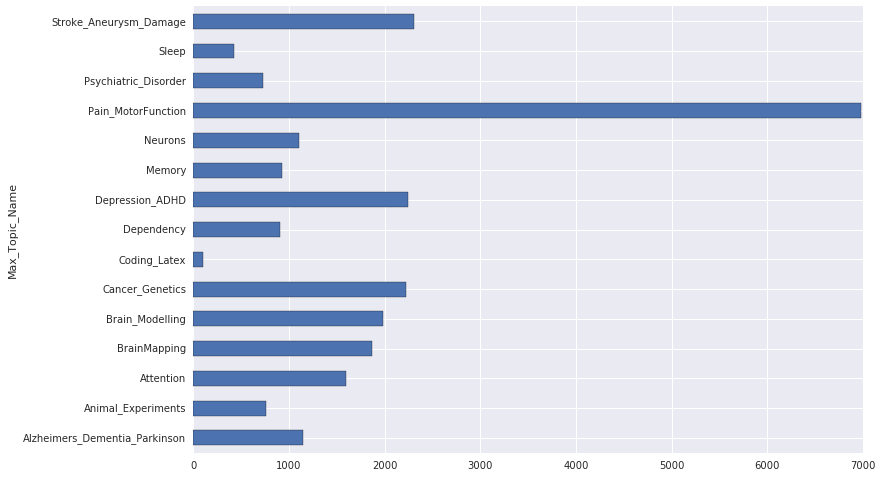

In [18]:
# Number of Documents for each max topic
fig = plt.figure(figsize=(12,8))
ax = plt.gca()
text_nmf.groupby('Max_Topic_Name').size().plot(kind = 'barh', ax = ax)
plt.savefig('imgs/Top_Topics_by_DocCount.png', dpi = 200, facecolor = 'grey')

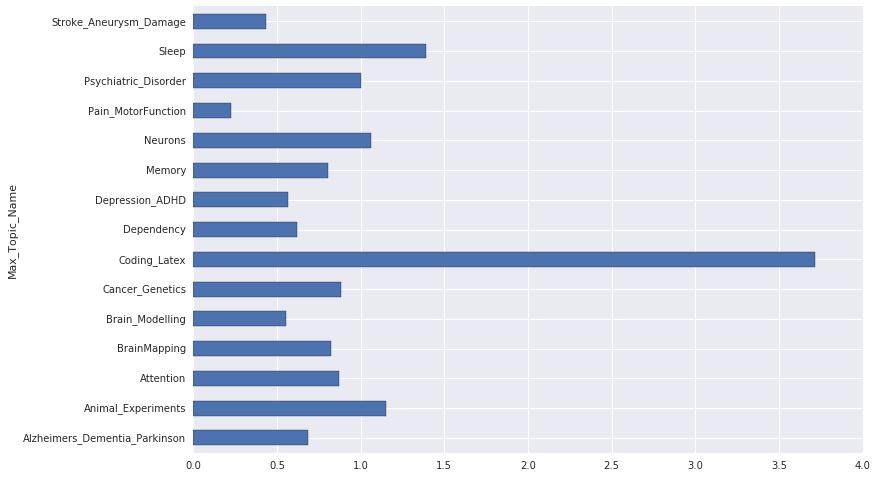

In [19]:
# Median Values for each Max Topic
fig = plt.figure(figsize=(12,8))
ax = plt.gca()
text_nmf.groupby('Max_Topic_Name').Max_Topic_Val.median().plot(kind = 'barh')
plt.savefig('imgs/Top_Topics_by_nmfValue.png', dpi = 200, facecolor = 'grey')

### HEIRARCHICAL CLUSTERING

In [27]:
# HEIRARCHICAL CLUSTERING BY COSINE DISTANCE
# LOTS OF ZEROS...

links = linkage(text_nmf.ix[:,:-5], metric = 'cosine', method = 'average')


with open('WranglingPickles/links.pkl', 'wb') as f:
    pickle.dump(links, f)

In [10]:
links = None
with open('WranglingPickles/links.pkl', 'rb') as f:
    links = pickle.load(f)

In [28]:
getsizeof(links)

810544

In [29]:
np.set_printoptions(suppress=True) # THIS IS GREAT - NO SCI NOTATION
print(links[:10])

[[  1822.  14431.      0.      2.]
 [   967.   1383.      0.      2.]
 [  1746.  25328.      0.      3.]
 [  2088.  25329.      0.      4.]
 [  2093.  25330.      0.      5.]
 [  2129.  25331.      0.      6.]
 [  2187.  25332.      0.      7.]
 [  2292.  25333.      0.      8.]
 [  2314.  25334.      0.      9.]
 [  2328.  25335.      0.     10.]]


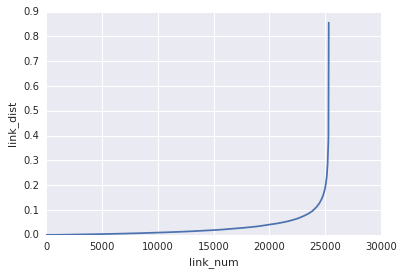

In [31]:
plt.plot(links[:,2])
plt.xlabel("link_num")
plt.ylabel("link_dist")

In [32]:
text_nmf.head()

,Dependency_DrugAddiction,Coding_Latex,Learning_BrainFuncModelling,Stroke_Aneurysm_Damage,Aging_Memory_BehaviorFunctionality,Attention??,Pyschiatric_Disorder,Cancer_Genetics,Depression_ADHD,Surgery_Spinal_MotorFunc??,NeuroTransmitters,Sleep,BrainMapping,Aging_Alzheimers_Dementia_Parkinson,Animal_Experiments,ID,Journal,Date,Max_Topic_Name,Max_Topic_Val
0,0.077289,0.000000,0.423614,0.000000,0.000000,0.000000,0.000000,0.000000,0.005189,0.000000,0.122692,0.000000,0.01533,0.003125,0.000000,581de0c1b067bc05a3644f24,ACS_Chem_Neurosci,2014_Sep,Learning_BrainFuncModelling,0.423614
1,0.911721,0.000000,0.343781,0.025851,0.169139,0.005566,0.000000,0.000000,0.000000,0.069749,0.248388,0.000000,0.00000,0.061312,0.120857,581de0c1b067bc05a3644f25,ACS_Chem_Neurosci,2014_Sep,Dependency_DrugAddiction,0.911721
2,0.463397,0.009915,0.088257,0.000000,0.114621,0.171793,0.073244,0.064022,0.000000,0.003221,0.135721,0.295106,0.00000,0.238809,0.000000,581de0c1b067bc05a3644f26,ACS_Chem_Neurosci,2014_Nov,Dependency_DrugAddiction,0.463397
3,0.175912,0.000000,0.947493,0.000000,0.584139,0.513558,0.034347,0.000000,0.000000,0.260069,0.525507,0.000000,0.00000,0.000000,0.000000,581de0c1b067bc05a3644f27,ACS_Chem_Neurosci,2014_Nov,Learning_BrainFuncModelling,0.947493
4,0.226121,0.000000,0.000000,0.000000,0.000000,0.075410,0.000000,0.000000,0.000000,0.089277,0.123127,0.000000,0.02235,0.000000,0.000000,581de0c1b067bc05a3644f28,ACS_Chem_Neurosci,2014_Jul,Dependency_DrugAddiction,0.226121


In [34]:
# PAIRWISE (COSINE) DISTANCE BETWEEN EVERY POINT!
distVect = pdist(text_nmf.ix[:,:-5], metric = 'cosine')
print(distVect.shape)

(320715801,)


In [35]:
# COMPUTE COPHENETIC CORRELATION
# Cophenetic Correlation is how faithfully the clusters of the linkage matrix 
# preserve the pairwise distance of the individual points
cophenet(links, distVect)[0] # this seems good...

0.72243116824319975

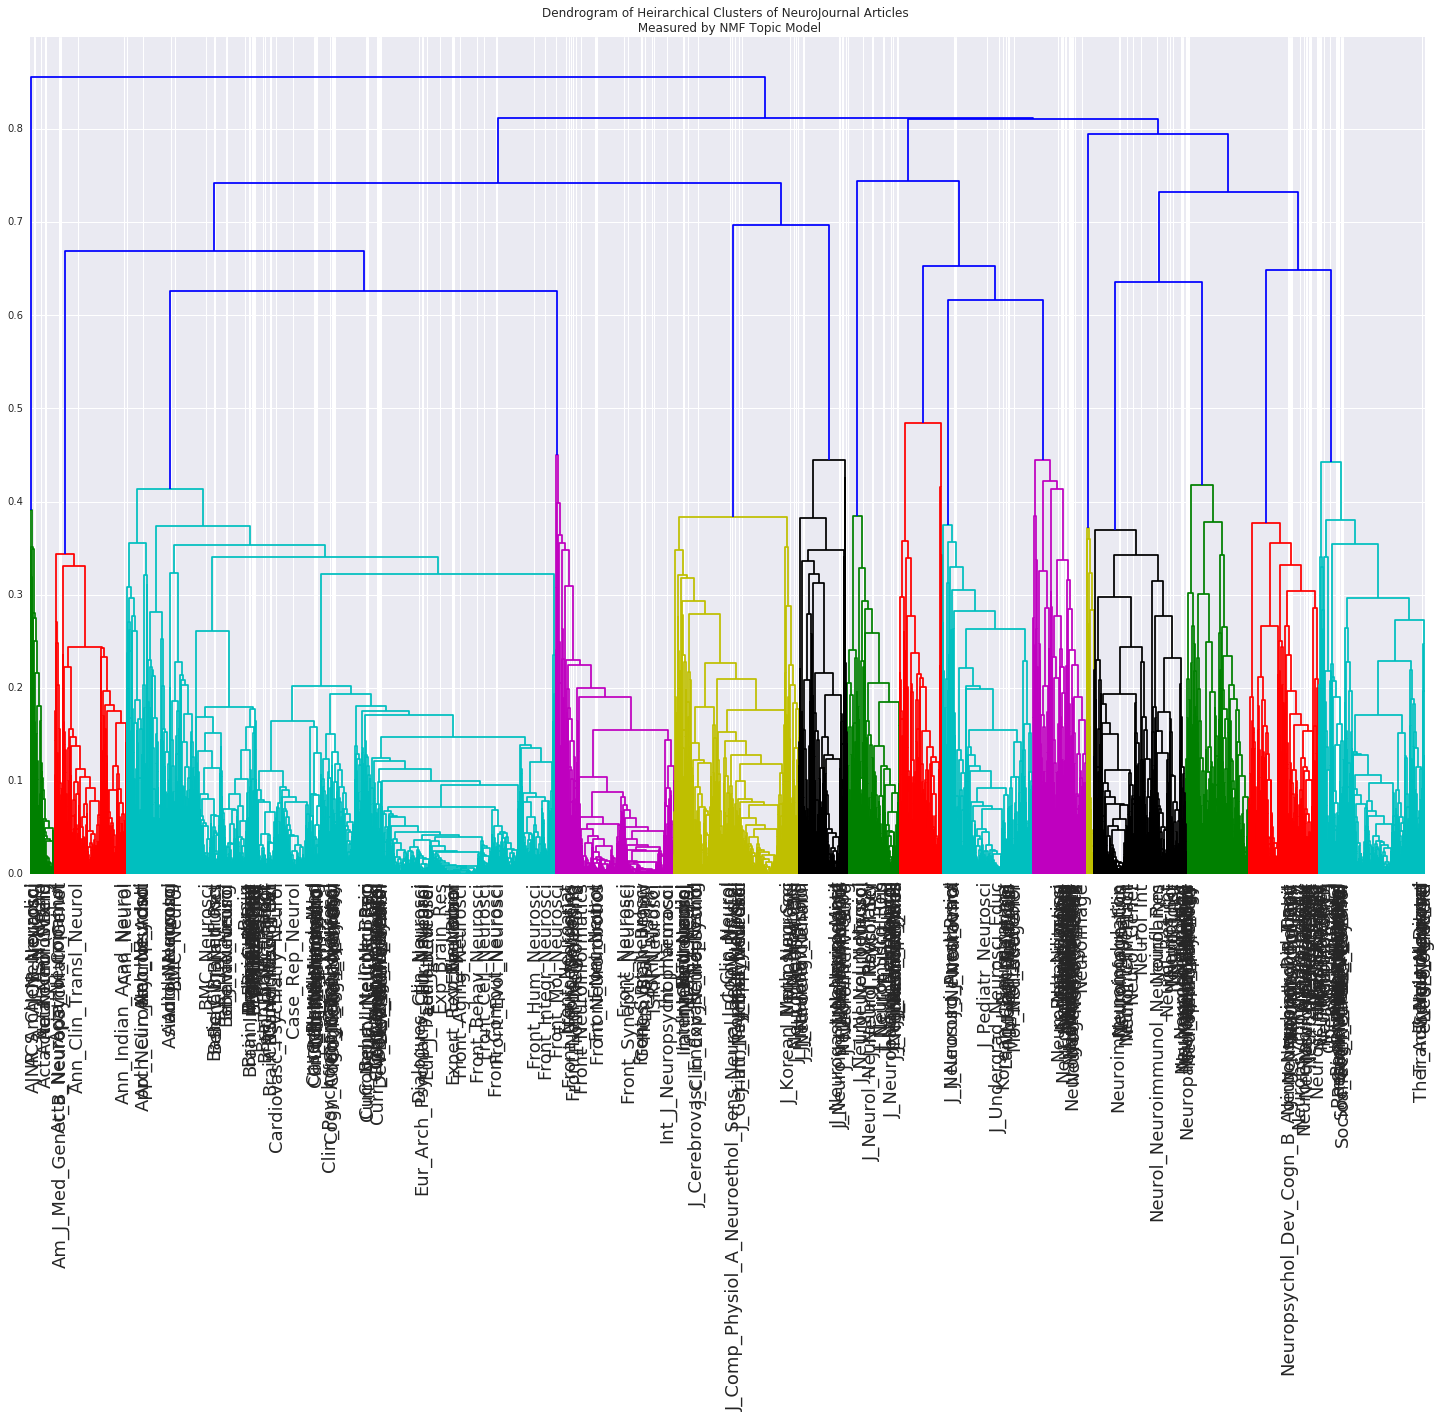

In [36]:
# GRAPH DENDROGRAM
fig = plt.figure(figsize=(25,15))
plt.title("Dendrogram of Heirarchical Clusters of NeuroJournal Articles \n Measured by NMF Topic Model")
dendrogram(links)
ax = plt.gca()

ticks = text_nmf.groupby('Journal').size().cumsum().values
ticklabels = text_nmf.groupby('Journal').size().cumsum().index

ax.set_xticks(ticks*10)
ax.set_xticklabels(ticklabels)

plt.xticks(rotation = 90, fontsize = 18)

plt.savefig('aggClust.png', dp = 200, facecolor = 'grey')

In [ ]:
# IGNORE FOR NOW, WANT TO FIND COLOR COORDINATES

lines = ax.get_children()[:7]
groupidxs = []

l1 = lines[1]
l1.get_color() #  all green
len(l1.get_paths()) # THESE WILL BE INDICES??

### Choosing Grouping

Trying different groupings will tell you different things about the clusters.
For Example:

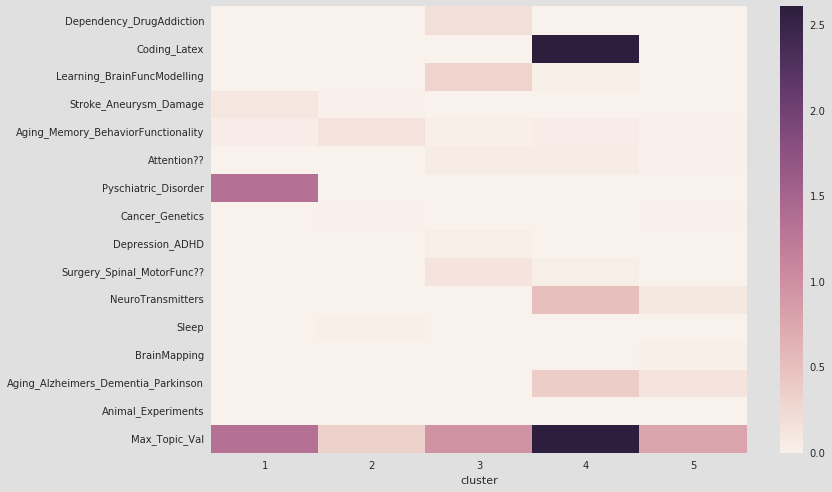

In [29]:
# FLATTEN INTO 5 GROUPS
'''
with 5 clusters we are really seeing two distinct characteristics:
    - you can group articles based on heavy use of code
    - articles about psychiatric disorders
'''
fig = plt.figure(figsize=(12,8))
clusters = fcluster(links, 5, criterion = 'maxclust')
text_nmf['cluster']= clusters

sns.heatmap(text_nmf.groupby('cluster').median().T, )

plt.subplots_adjust(wspace = 0.35)
fig.set_facecolor('0.88')

plt.savefig('clusters5.png', dpi = 200, facecolor = 'grey')

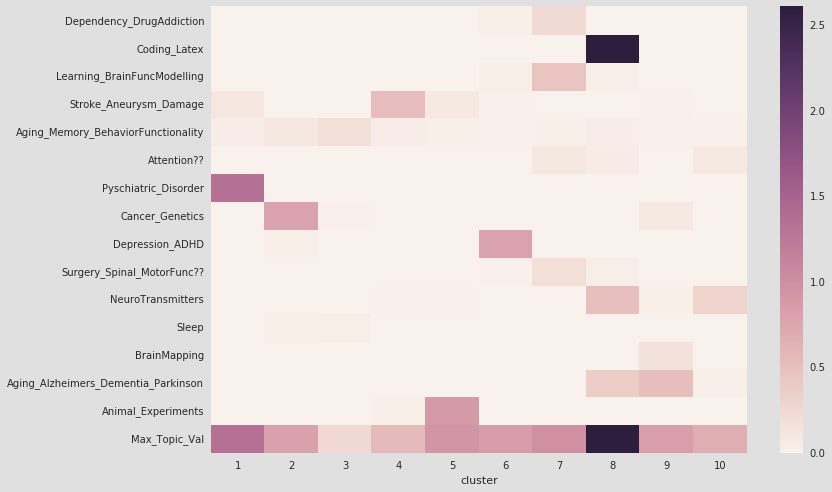

In [31]:
# FLATTEN INTO 10 GROUPS
'''
with 10 start to see more meaningful clusters (based on my topic features):
    - cluster 2 --> cancer genetics
    - cluster 4 --> stroke/aneurysm/damage
    - Cluster 5 --> animal Experiments
    - Cluster 6 --> Depression_ADHD
    - More spread out for clusters 7 - 10
'''
fig = plt.figure(figsize=(12,8), facecolor='0.88')
clusters = fcluster(links, 10, criterion = 'maxclust')
text_nmf['cluster']= clusters

sns.heatmap(text_nmf.groupby('cluster').median().T)
plt.subplots_adjust(wspace = 0.35)
plt.savefig('clusters10.png', dpi = 200, facecolor = 'grey')

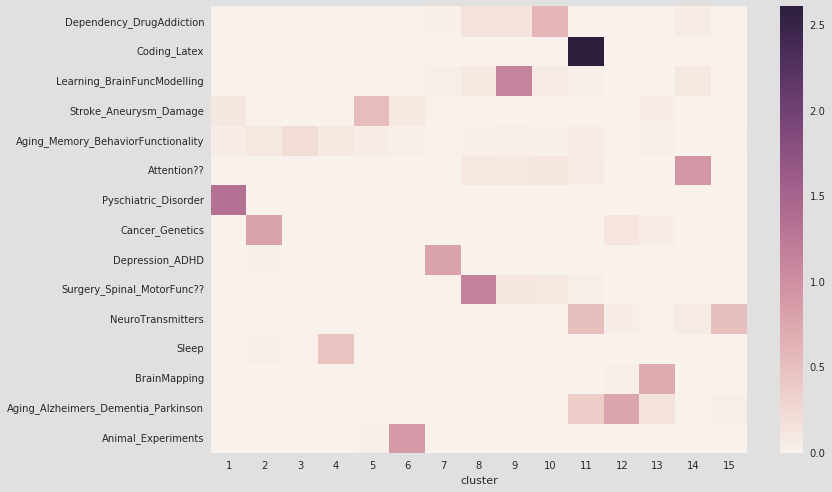

In [34]:
# FLATTEN INTO 15 GROUPS
'''
I'm kinda thinking of this as a test for how good my topic model is
In the ideal situation, each of 15 clusters would be defined by a single topic ftr
It does look like for at least the first 10 features, each cluster has a clear topic ftr that makes up 
    a noticeably stronger portion of the cluster than any other ftr
For Features 10 - 15 this correlation gets weaker.
My Theory:
    - The heavy use of code is pervasive throughout many different types of articles 
    and therefore grabbing that as a main feature lumps together articles that would otherwise have different topics.
    - This leaves a large chunk of articles that don't qualify as "Heavy Code" articles 
    that could have otherwise been grouped better had the "Heavy Code" articles been split up
    - This leads to more overlap in grouping-topics which our algorithm tries to group but ends up being vague/general
'''
fig = plt.figure(figsize=(12,8), facecolor='0.88')
clusters = fcluster(links, 15, criterion = 'maxclust')
text_nmf['cluster']= clusters

sns.heatmap(text_nmf.drop('Max_Topic_Val', axis = 1).groupby('cluster').median().T)
plt.subplots_adjust(wspace = 0.35)
plt.savefig('clusters15.png', dpi = 200, facecolor = 'grey')

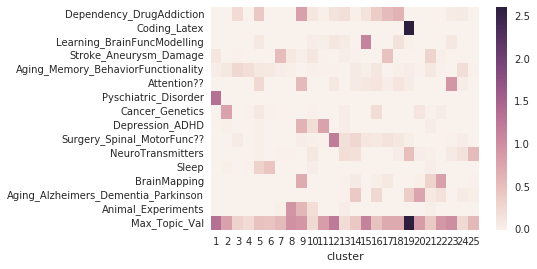

In [19]:
# FLATTEN INTO 25 GROUPS for fun
'''
 dividing into more groups might help de-tangle the "vague" clusters seen previously
 but would lose the clarity of the first few clusters.
'''

clusters = fcluster(links, 25, criterion = 'maxclust')
text_nmf['cluster']= clusters

sns.heatmap(text_nmf.groupby('cluster').median().T)

plt.savefig('clusters25.png', dpi = 200, facecolor = 'grey')

## Back to Mongo

In [20]:
text_nmf.shape

(25327, 20)

In [21]:
client = mongo.MongoClient()
client.database_names()

['local', 'project4', 'heavyMetalDB', 'example_db']

In [22]:
db = client.project4

In [23]:
text_nmf.columns
test = db.get_collection('ACS_Chem_Neurosci')
testix = text_nmf.ix[0,'ID']

In [24]:
journals = db.collection_names()
db.ACS_Chem_Neurosci.find({})[1]
;

''

In [25]:
# THESE ARE OLD NAMES
for j in journals[:-1]:
    coll = db.get_collection(j)
    coll.update_many({},{"$unset": {
                'Dependency_DrugAddiction': "",
                'Learning_BrainFuncModelling': '',
                'Memory_BehaviorFunctionality':'',
                'Surgery_Spinal_MotorFunc': '',
                'NeuroTransmitters': "",
                'Aging_Alzheimers_Dementia_Parkinson': '',
                'Pyschiatric_Disorder': '',
                'Aging_Memory_BehaviorFunctionality':''
            }})

In [26]:
def sendToMongo(jnl):
    collec = db.get_collection(jnl)
    data = text_nmf[text_nmf.Journal == jnl]
    for idx in data.index:
        collec.update_one(
        {'_id':data.ix[idx, 'ID']},
        {
            "$set": {
                     'Dependency' : data.ix[idx,'Dependency'], 
                     'Coding_Latex' : data.ix[idx,'Coding_Latex'],
                     'Brain_Modelling' : data.ix[idx,'Brain_Modelling'], 
                     'Stroke_Aneurysm_Damage' : data.ix[idx,'Stroke_Aneurysm_Damage'],
                     'Memory' : data.ix[idx,'Memory'], 
                     'Attention' : data.ix[idx,'Attention'],
                     'Psychiatric_Disorder' : data.ix[idx,'Psychiatric_Disorder'], 
                     'Cancer_Genetics' : data.ix[idx,'Cancer_Genetics'], 
                     'Depression_ADHD' : data.ix[idx,'Depression_ADHD'],
                     'Pain_MotorFunction' : data.ix[idx,'Pain_MotorFunction'], 
                     'Neurons' : data.ix[idx,'Neurons'], 
                     'Sleep' : data.ix[idx,'Sleep'],
                     'BrainMapping': data.ix[idx,'BrainMapping'], 
                     'Alzheimers_Dementia_Parkinson' : data.ix[idx,'Alzheimers_Dementia_Parkinson'],
                     'Animal_Experiments' : data.ix[idx,'Animal_Experiments'],
                     'Max_Topic_Name' : data.ix[idx,'Max_Topic_Name'],
                     'Max_Topic_Val': data.ix[idx,'Max_Topic_Val']
                }
            }
        )
    return jnl    
    


In [27]:
for j in text_nmf.Journal.unique():
    sendToMongo(j)

In [28]:
# OK THERE ALL IN MONGO NOW! HOORAY... MAKE APP!

In [29]:
len(db.collection_names())
len(journals)

277

In [30]:
sleep_ids = []
for coll in db.collection_names():
    col = db[coll]
    sleep_ids.extend(list(col.find({'Max_Topic_Name': 'Sleep'},{"_id":1})))
    
len(sleep_ids)

431

In [31]:
rid = np.random.choice(sleep_ids)['_id']

results = []
for coll in db.collection_names():
    col = db[coll]
    results.extend(list(col.find({'_id': rid},{'_id':0})))

len(results)

1

In [32]:
results

[{'Alzheimers_Dementia_Parkinson': 0.010596690063297895,
  'Animal_Experiments': 0.025049633599523884,
  'Attention': 0.06172885193527501,
  'BrainMapping': 0.19986087086008203,
  'Brain_Modelling': 0.06293534997148867,
  'Cancer_Genetics': 0.0,
  'Coding_Latex': 0.0,
  'Dependency': 0.0,
  'Depression_ADHD': 0.07308026852375336,
  'Max_Topic_Name': 'Sleep',
  'Max_Topic_Val': 2.563441122913041,
  'Memory': 0.0,
  'Neurons': 0.055144260996456,
  'Pain_MotorFunction': 0.006107602282129815,
  'Psychiatric_Disorder': 0.0,
  'Sleep': 2.563441122913041,
  'Stroke_Aneurysm_Damage': 0.0,
  'date': '2012_Apr',
  'pages': '60',
  'text': '\n==== Front\nFront NeurolFront NeurolFront. Neur.Frontiers in Neurology1664-2295Frontiers Research Foundation 2253619510.3389/fneur.2012.00060NeuroscienceOriginal ResearchIncreased Corticomuscular Coherence in Idiopathic REM Sleep Behavior Disorder Jung Ki-Young 1*Cho Jae-Hyun 23Ko Deokwon 14Seok Hung Youl 1Yoon Ho-Kyoung 5Lee Heon-Jeong 5Kim Leen 5Im Chang-H